In [ ]:
Output:

A .tiff image file with 50 channels.
Channels correspond to the following biomarkers:

DAPI, CD45, CD68, CD14, PD1, FoxP3, CD8, HLA-DR, PanCK, CD3e, CD4, aSMA, CD31, 
Vimentin, CD45RO, Ki67, CD20, CD11c, Podoplanin, PDL1, GranzymeB, CD38, CD141, CD21, 
CD163, BCL2, LAG3, EpCAM, CD44, ICOS, GATA3, Gal3, CD39, CD34, TIGIT, ECad, CD40, VISTA, 
HLA-A, MPO, PCNA, ATM, TP63, IFNg, Keratin8/18, IDO1, CD79a, HLA-E, CollagenIV, CD66

In [1]:
# Step 1: Read Tiff Image
import tifffile 
import numpy as np
import matplotlib.pyplot as plt
import os.path as path

root_dir = "/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/ProcessedData_npy_new_dir/ProcessedData_npy"
# Path to TIFF file
image_name = "TCGA-5P-A9K0-01Z-00-DX1_1_0_512"
original_image_name= image_name+".png"
image_root_dir = root_dir + f"/images"
rosie_root_dir = root_dir + f"/markers/{image_name}.tiff"
rosie_marker_name = image_name + "_ROSIE.tiff"

original_image_path = path.join(image_root_dir, original_image_name)
rosie_path = path.join(rosie_root_dir, rosie_marker_name)

#Original image
original_image = plt.imread(original_image_path)

# Read all channels
rosie_data = tifffile.imread(rosie_path)

print("Original Image Shape:", original_image.shape)
print("Original Image Data type:", original_image.dtype)
print("Rosie Output Shape:", rosie_data.shape)
print("Rosie Output Data type:", rosie_data.dtype)

Original Image Shape: (512, 512, 3)
Original Image Data type: float32
Rosie Output Shape: (50, 512, 512)
Rosie Output Data type: float32


In [2]:
# Biomarkers (50)
biomarkers = [
    "DAPI", "CD45", "CD68", "CD14", "PD1", "FoxP3", "CD8", "HLA-DR", "PanCK", "CD3e",
    "CD4", "aSMA", "CD31", "Vimentin", "CD45RO", "Ki67", "CD20", "CD11c", "Podoplanin", 
    "PDL1", "GranzymeB", "CD38", "CD141", "CD21", "CD163", "BCL2", "LAG3", "EpCAM",
    "CD44", "ICOS", "GATA3", "Gal3", "CD39", "CD34", "TIGIT", "ECad", "CD40", "VISTA",
    "HLA-A", "MPO", "PCNA", "ATM", "TP63", "IFNg", "Keratin8/18", "IDO1", "CD79a",
    "HLA-E", "CollagenIV", "CD66"
]

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def show_rosie_channel(rosie_data, original_image=None, biomarkers=None, channel_index=0, cmap="gray"):
    """
    Display a specific channel from a multi-channel ROSIE (or CODEX-style) TIFF image,
    optionally next to the original RGB image.

    Args:
        rosie_data (np.ndarray): 3D array (C, H, W), where C = number of channels
        original_image (np.ndarray, optional): RGB image (H, W, 3) to display beside the channel
        biomarkers (list[str], optional): list of biomarker names, len = C
        channel_index (int): index of the channel to visualize
        cmap (str): matplotlib colormap for grayscale display
    """
    # --- Validate input ---
    if channel_index >= rosie_data.shape[0]:
        raise IndexError(f"Channel index {channel_index} out of range (max {rosie_data.shape[0]-1})")

    # --- Get biomarker name safely ---
    if biomarkers is not None and channel_index < len(biomarkers):
        channel_name = biomarkers[channel_index]
    else:
        channel_name = "Unknown"

    # --- Extract and normalize the selected channel ---
    channel_image = rosie_data[channel_index].astype(np.float32)
    channel_image = (channel_image - channel_image.min()) / (channel_image.max() - channel_image.min() + 1e-6)

    # --- Plot setup ---
    if original_image is not None:
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(original_image)
        axes[0].set_title("Original Image")
        axes[0].axis("off")

        axes[1].imshow(channel_image, cmap=cmap)
        axes[1].set_title(f"Channel {channel_index}: {channel_name}")
        axes[1].axis("off")

    else:
        plt.figure(figsize=(6, 6))
        plt.imshow(channel_image, cmap=cmap)
        plt.title(f"Channel {channel_index}: {channel_name}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

    return channel_image


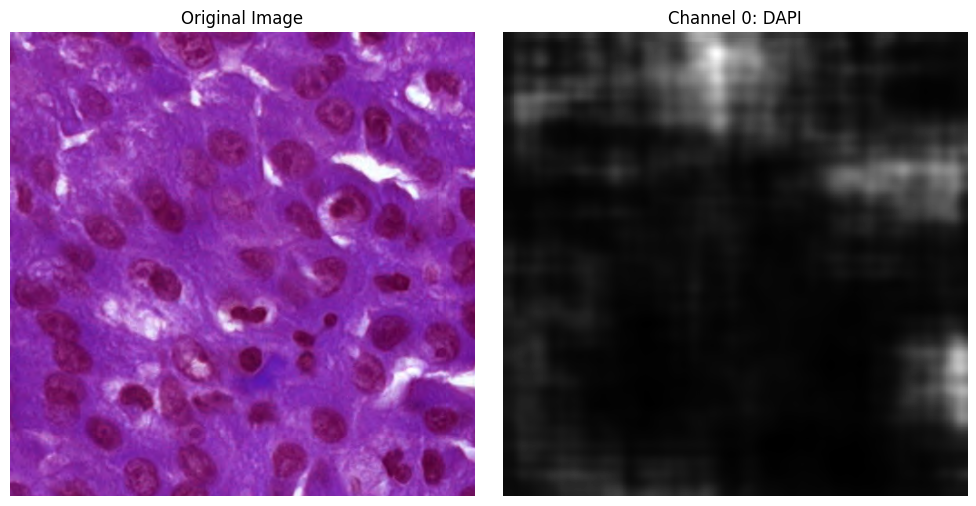

In [5]:
channel_index = 0  # choose DAPI for example

channel_image = show_rosie_channel(
    rosie_data=rosie_data,
    original_image=original_image,
    biomarkers=biomarkers,
    channel_index=channel_index,
)


In [8]:
import numpy as np
import tifffile
import matplotlib.pyplot as plt
import random

def create_colored_codex_image(
    tiff_data,
    biomarkers,
    color_map=None,
    save_path="composite_codex.tiff",
    seed=42,
    show_legend=True,
    min_signal_threshold=1e-3,
    original_image=None,   # NEW
):
    """
    Create a pseudo-colored composite image from multi-channel CODEX data (with optional legend overlay).

    Args:
        tiff_data (np.ndarray): shape (N, H, W) with N biomarkers
        biomarkers (list[str]): list of biomarker names
        color_map (dict): biomarker_name -> (R, G, B) in [0–1]; missing colors will be random
        save_path (str): output TIFF path
        seed (int): random seed for reproducibility
        show_legend (bool): display color legend
        min_signal_threshold (float): minimum signal threshold for active channels
        original_image (np.ndarray, optional): RGB image to show beside composite
    """
    random.seed(seed)
    np.random.seed(seed)
    color_map = color_map or {}

    H, W = tiff_data.shape[1], tiff_data.shape[2]
    composite = np.zeros((H, W, 3), dtype=np.float32)

    # Keep track of markers actually used (nonempty)
    active_markers = []

    for i, marker in enumerate(biomarkers):
        channel = tiff_data[i].astype(np.float32)
        # Skip empty channels
        if channel.max() < min_signal_threshold:
            continue

        # Normalize
        channel = (channel - channel.min()) / (channel.max() - channel.min() + 1e-6)

        # Assign color
        if marker not in color_map:
            color_map[marker] = tuple(np.random.rand(3))
            #print(f"[INFO] Random color assigned for {marker}: {color_map[marker]}")

        color = np.array(color_map[marker]).reshape(1, 1, 3)
        composite += channel[..., None] * color
        active_markers.append(marker)

    composite = np.clip(composite / (composite.max() + 1e-6), 0, 1)
    tifffile.imwrite(save_path, (composite * 255).astype(np.uint8))
    print(f"\n✅ Saved composite image at: {save_path}")

    # --- Visualization ---
    if original_image is not None:
        fig, axes = plt.subplots(1, 2, figsize=(14, 7))
        axes[0].imshow(original_image)
        axes[0].axis("off")
        axes[0].set_title("Original Image")

        axes[1].imshow(composite)
        axes[1].axis("off")
        axes[1].set_title(f"Composite CODEX-like Image ({len(active_markers)} markers)")

        # Add legend to right image if requested
        if show_legend and len(active_markers) > 0:
            handles = [
                plt.Line2D([0], [0], color=color_map[m], lw=8, label=m)
                for m in active_markers
            ]
            ncol = 1 if len(active_markers) <= 10 else 2
            axes[1].legend(
                handles=handles,
                loc='upper right',
                bbox_to_anchor=(1.35, 1.0),
                frameon=False,
                ncol=ncol,
                fontsize=8,
            )

        plt.tight_layout()
        plt.show()

    else:
        # show only the composite
        plt.figure(figsize=(8, 8))
        plt.imshow(composite)
        plt.axis('off')
        plt.title(f"Composite CODEX-like Image ({len(active_markers)} markers)")

        if show_legend and len(active_markers) > 0:
            handles = [
                plt.Line2D([0], [0], color=color_map[m], lw=8, label=m)
                for m in active_markers
            ]
            ncol = 1 if len(active_markers) <= 10 else 2
            plt.legend(
                handles=handles,
                loc='upper right',
                bbox_to_anchor=(1.35, 1.0),
                frameon=False,
                ncol=ncol,
                fontsize=8,
            )

        plt.tight_layout()
        plt.show()

    return composite, color_map



✅ Saved composite image at: composite_codex.tiff


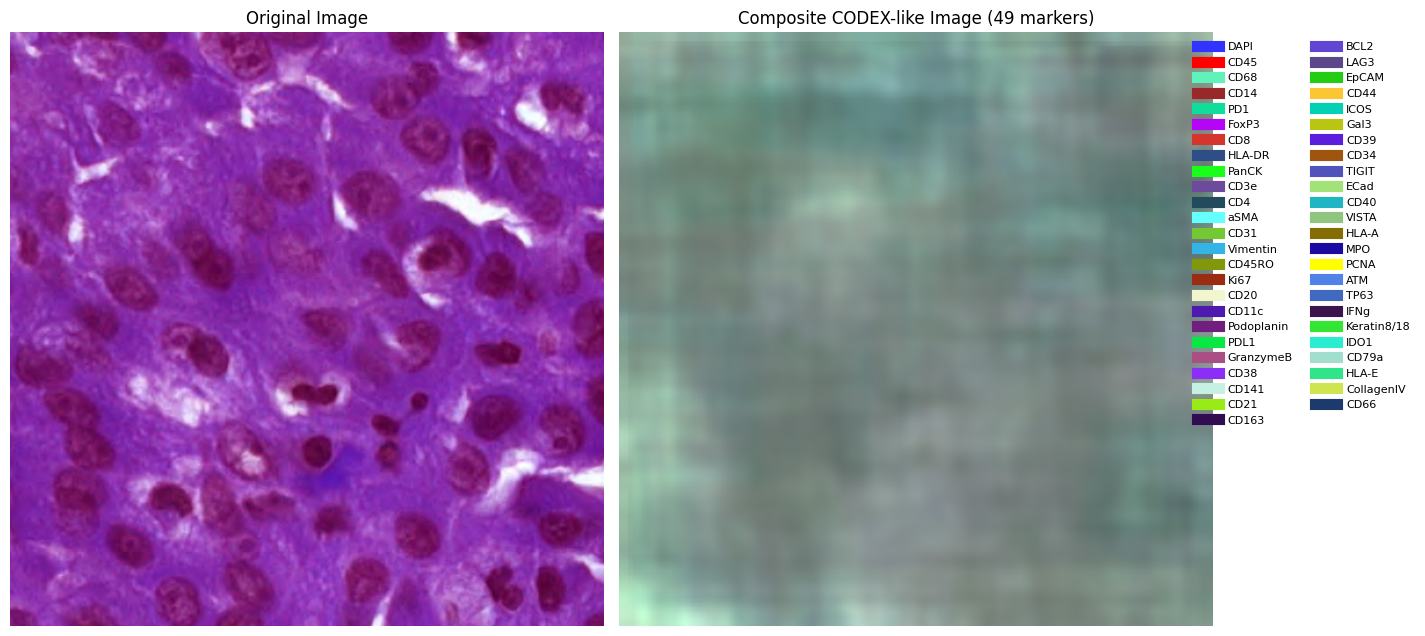

In [9]:
# Example color map (partial)
preset_colors = {
    "DAPI": (0.2, 0.2, 1.0),
    "CD45": (1.0, 0.0, 0.0),
    "PanCK": (0.1, 1.0, 0.1),
    "aSMA": (0.4, 1.0, 1.0),
    "Vimentin": (0.2, 0.7, 0.9),
    "PCNA": (1.0, 1.0, 0.0),
    "Keratin8/18": (0.2, 0.9, 0.2),
}

# Run the function
composite, final_colors = create_colored_codex_image(
    rosie_data,
    biomarkers,
    color_map=preset_colors,
    original_image=original_image,  # original PNG image
)